## Imports

Prerequisites
* Install Python 3.12. At the time this was written, PyTorch did not support Python versions higher than 3.12.
* Create a virtual environment: `python -m venv .venv`.
* Activate the virtual environment: `.venv\Scripts\activate`
* Install required Python packages. Either
  * Use the latest versions: `pip install numpy matplotlib torch torchsummary ipykernel ipympl`
  * Use the versions frozen in requirements.txt: `pip install -r requirements.txt`

Let's import some packages that will be used throught this notebook.

In [1]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Example Function

Let's define a simple function `f(x)` that we'd like to approximate. We'll take `n` samples uniformly spaced along the x-axis in the closed interval `[x0, x1]` and store the x and y coordinates in the variables `x`, and `y`,

Note that if you change the definition of `f(x)`, you may also have to adjust `x0`, `x1`, and `n` to get a representative
set of samples over an interesting domain.

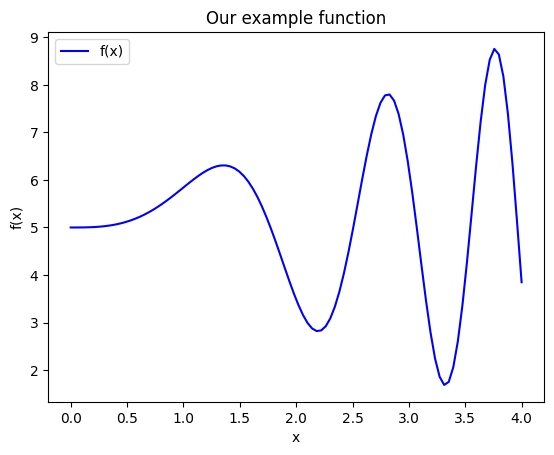

In [2]:
f = lambda x: np.sin(x**2) * x + 5
# f = lambda x: np.sin(x) + 5

x0 = 0    # Left side of domain
x1 = 4    # Right side of domain
n = 100   # Number of samples

x = np.linspace(x0, x1, n)
y = np.vectorize(f)(x)

plt.plot(x, y, label="f(x)", color="blue")
plt.title("Our example function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

# Piecewise-Linear Approximation

We'll use a naive, greedy algorithm to generate a continuous, piecewise linear function that approximates `f(x)`, with a bias towards shorter line segments in regions where the slope of `f(x)` changes more rapidly.

This approximation will be stored in the `segments` array. Each segment is a tuple of `(i, j, error)` where `range(i, j)` specifies indices into the `x` array, and `error` is a tuple of mean, total, and max y-deviation between the segment and values of array `y`.

Note that if you change the definition of `f(x)` you may need to adjust the `epsilon_total` and `epsilon_max` parameters to get a decent approximation.

Approximating function f(x) with 31 linear segments.


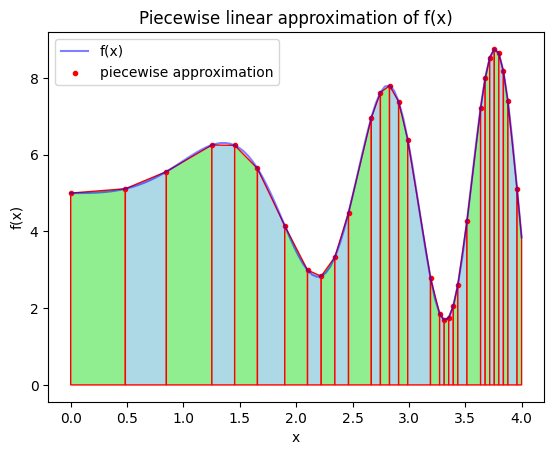

In [3]:
def compute_errors(x, y, i, j):
    if j - i == 1:
        return (0, 0, 0)
    m = (y[j - 1] - y[i]) / (x[j - 1] - x[i])
    b = y[i]
    errors = [abs((m * (x[k] - x[i])) + b - y[k]) for k in range(i, j)]
    return np.mean(errors), np.sum(errors), np.max(errors)


# Finds the longest run where the average error is less than epsilon
def next_segment(x, y, epsilon_total, epsilon_max, i):
    best_segment = None
    j = i + 1
    while j <= len(x):
        error = compute_errors(x, y, i, j)
        mean, total, max = error
        
        if total > epsilon_total:
            break
        if max > epsilon_max:
            break
        best_segment = (i, j, error)
        j += 1
    return best_segment


def piecewise(x, y, epsilon_total, epsilon_max, pieces):
    i = 0
    while i < len(x) - 1:
        piece = next_segment(x, y, epsilon_total, epsilon_max, i)
        pieces.append(piece)
        i = piece[1] - 1
    return pieces


# segments = piecewise(x, y, 0.05, [])
segments = piecewise(x, y, 0.35, .1, [])

fig, ax = plt.subplots()
for i, s in enumerate(segments):
    vertices = [
        (x[s[0]], 0),
        (x[s[0]], y[s[0]]),
        (x[s[1] - 1], y[s[1] - 1]),
        (x[s[1] - 1], 0),
    ]
    color = "lightgreen" if i % 2 == 0 else "lightblue"
    polygon = patches.Polygon(
        vertices, closed=True, fill=True, edgecolor="r", facecolor=color
    )
    ax.add_patch(polygon)

print(f"Approximating function f(x) with {len(segments)} linear segments.")

plt.plot(x, y, label="f(x)", color="blue", alpha=0.5)
plt.scatter([x[s[0]] for s in segments], [y[s[0]] for s in segments], marker = ".", color="red", label="piecewise approximation")
plt.title("Piecewise linear approximation of f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

## Building a deep learning model to approximate `f(x)`

We can get a good approximation of `f(x)` using a model with two [dense layers](https://en.wikipedia.org/wiki/Layer_(deep_learning)), the first of which will use [RELU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation.

Let's create a a function to compute the weights and biases for this model. Given 
* **x:** samples of the domain of function `f(x)`
* **y:** corresponding values of `f(x)`
* **segments:** an array of `n` ranges of indices into `x` and `y`. Each range defines the extent of a single line segment.

Returns
* **m1:** a `1 x 2n` matrix of weights for the first layer
* **b1:** a `1 x 2n` vector of biases for the first layer
* **m2:** a `2n x 1` matrix of weights for the second layer
* **b2:** a `1 x 1` vector containing the single bias value for the second layer

In [4]:
def weights_and_biases(x, y, segments):
  m1 = []
  b1 = []
  m2 = []

  for s in segments:
    start = x[s[0]]
    slope = (y[s[1] -1] - y[s[0]]) / (x[s[1] - 1] - x[s[0]])
    end = x[s[1] - 1]

    if (slope >= 0):
      m1.append(slope)
      b1.append(-slope * start)
      m2.append(1)

      m1.append(slope)
      b1.append(-slope * end)
      m2.append(-1)
    else:
      m1.append(-slope)
      b1.append(slope * start)
      m2.append(-1)

      m1.append(-slope)
      b1.append(slope * end)
      m2.append(1)
  b2 = [y[segments[0][0]]]
  return m1, b1, m2, b2

Let's use these weights and biases to construct a Python function that implements the model. The plot shows the result of the model along with the original function `f(x)`.

mean error for g(x): 0.030868657770765355


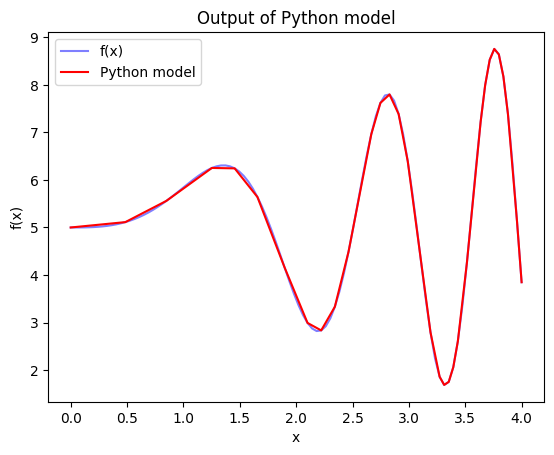

In [5]:
def build_python_model(wb):
    def relu(x):
        return max(0.0, x)

    m1, b1, m2, b2 = wb
    m1 = np.array(m1, dtype=np.float32)
    b1 = np.array(b1, dtype=np.float32)
    m2 = np.array(m2, dtype=np.float32)
    b1 = np.array(b1, dtype=np.float32)

    def f(x):
        layer1 = [relu(m1[i] * x + b1[i]) for i in range(len(m1))]
        sum = b2[0]
        for i in range(0, len(layer1)):
            sum += layer1[i] * m2[i]
        return sum

    return f

g = build_python_model(weights_and_biases(x, y, segments))

# Bring in Evaluate class that computes statistics on abs(f(a) - g(a))
# for values of a in x.
from helpers import Evaluate
results = Evaluate(x, f, g)

print(f"mean error for g(x): {results.mean}")

plt.plot(x, results.y1, label="f(x)", color="blue", alpha=0.5)
plt.plot(x, results.y2, label="Python model", color="red")
plt.title("Output of Python model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

Let's write some utiltiies to help evaluate the model.

In [6]:
# """
# A class to generate unique random floats within a range.
# We will use this class to generate training, validation, and evaluation data.
# """
# class UniqueRandomFloatGenerator:
#     def __init__(self, low, high, precision=5):
#         """
#         Initialize the generator with a range and precision.
        
#         :param low: The lower bound of the range.
#         :param high: The upper bound of the range.
#         :param precision: The precision (decimal places) for uniqueness.
#         """
#         self.low = low
#         self.high = high
#         self.precision = precision
#         self.generated = set()
    
#     def next(self, n):
#         samples = []
#         for _ in range(n):          
#             sample = self.next_sample()
#             samples.append(sample)
#         return samples

#     def next_sample(self):
#         """
#         Generate a unique random sample from the range.
        
#         :return: A unique float within the specified range.
#         """
#         while True:
#             # Generate a random float in the range
#             sample = round(np.random.uniform(self.low, self.high), self.precision)
#             # Check if it's unique
#             if sample not in self.generated:
#                 self.generated.add(sample)
#                 return sample

# # Generates n samples of f(x) for values of x between x0 and x1
# # Sample has gaussian noise with standard deviation std_dev
# def sample(f, x, std_dev = 0):
#     y = np.vectorize(f)(x)
#     noise = np.random.normal(0, std_dev, len(x)) if std_dev > 0 else 0
#     return x, y + noise

# generator = UniqueRandomFloatGenerator(x[0], x[-1])
# evaluation = sample(f, generator.next(100))


# PyTorch Model

Now let's use the same weights and biases to create a [PyTorch](https://pytorch.org/) model.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 62]             124
            Linear-2                 [-1, 1, 1]              63
Total params: 187
Trainable params: 187
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
mean error for model_fun(x): 0.030868693245706312


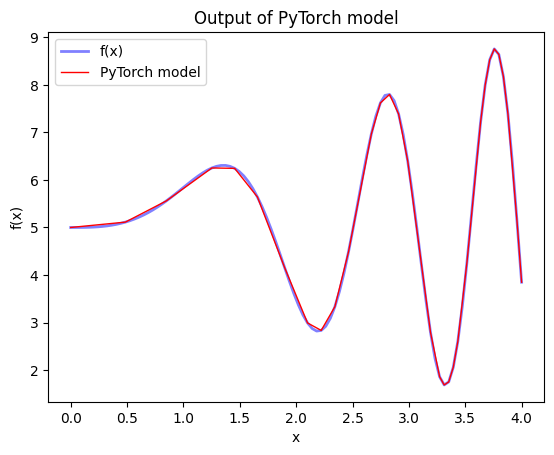

In [21]:
import torch
import torch.nn as nn
from torchsummary import summary

# torch.backends.cudnn.deterministic = True
torch.set_default_device("cpu")

class PyTorchModel(nn.Module):
    def __init__(
        self,
        hidden_size,
        # wb,
    ):
        super(PyTorchModel, self).__init__()

        # (w1, b1, w2, b2) = wb
        input_size = 1
        # hidden_size = len(b1)
        output_size = 1

        # Define two linear layers
        self.layer1 = nn.Linear(input_size, hidden_size, dtype=torch.float32)
        self.layer2 = nn.Linear(hidden_size, output_size, dtype=torch.float32)

        # # Initialize weights using the arrays provided
        # self.layer1.weight = nn.Parameter(
        #     torch.tensor([[w] for w in w1], dtype=torch.float32)
        # )
        # self.layer1.bias = nn.Parameter(torch.tensor([b1], dtype=torch.float32))
        # self.layer2.weight = nn.Parameter(torch.tensor([w2], dtype=torch.float32))
        # self.layer2.bias = nn.Parameter(torch.tensor([b2], dtype=torch.float32))

    def set_weights_and_biases(self, wb):
        # Initialize weights and biases using the arrays provided
        (w1, b1, w2, b2) = wb
        self.layer1.weight = nn.Parameter(
            torch.tensor([[w] for w in w1], dtype=torch.float32)
        )
        self.layer1.bias = nn.Parameter(torch.tensor([b1], dtype=torch.float32))
        self.layer2.weight = nn.Parameter(torch.tensor([w2], dtype=torch.float32))
        self.layer2.bias = nn.Parameter(torch.tensor([b2], dtype=torch.float32))

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x
    
    def single(self, x):
        return self(torch.tensor([[x]], dtype=torch.float32)).item()

# model1 = PyTorchModel(weights_and_biases(x, y, segments))
wb = weights_and_biases(x, y, segments)
model1 = PyTorchModel(len(wb[1]))
model1.set_weights_and_biases(wb)


# Print the model summary
# Disabled because of
# RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double
summary(model1, (1, 1))

# h = lambda x: model1(torch.tensor([[x]], dtype=torch.float32)).item()
h = model1.single
results2 = Evaluate(x, f, h)

print(f"mean error for model_fun(x): {results2.mean}")

plt.plot(x, results2.y1, label="f(x)", color="#8080ff", linewidth=2)
plt.plot(x, results2.y2, label="PyTorch model", color="red", linewidth=1)
plt.title("Output of PyTorch model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

Let's compare our Python model with the PyTorch model. They should be nearly identical.

See this note on [PyTorch numerical accuracy](https://pytorch.org/docs/stable/notes/numerical_accuracy.html).

mean error for abs(h(x) - g(x)): 1.4567747712135314e-07
total error for abs(h(x) - g(x)): 1.4567747712135315e-05
max error for abs(h(x) - g(x)): 7.599592208862305e-07


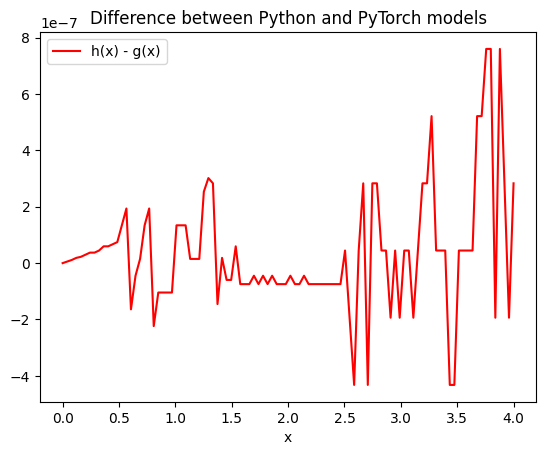

In [8]:
temp1 = Evaluate(x, g, h)
print(f"mean error for abs(h(x) - g(x)): {temp1.mean}")
print(f"total error for abs(h(x) - g(x)): {temp1.sum}")
print(f"max error for abs(h(x) - g(x)): {temp1.max}")

plt.plot(x, temp1.y1 - temp1.y2, label="h(x) - g(x)", color="red")
plt.title("Difference between Python and PyTorch models")
plt.xlabel("x")
# plt.ylabel("f(x)")
plt.legend()
plt.show()


The two functions look identical near the origin


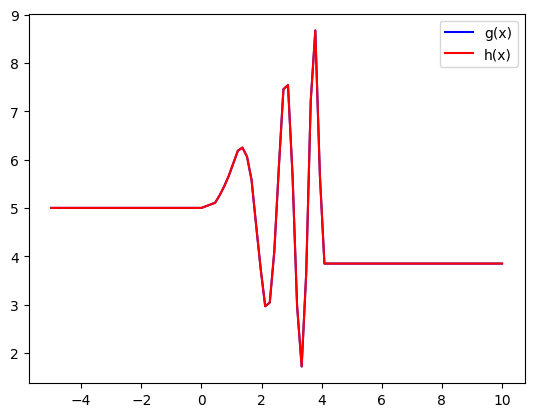

The two functions diverge further from the origin in the positive direction.


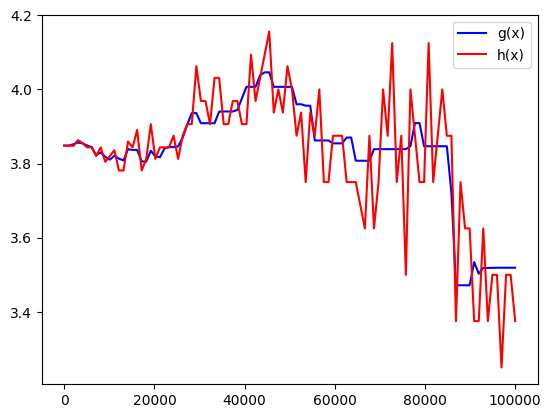

There is zero error to the left of the origin.


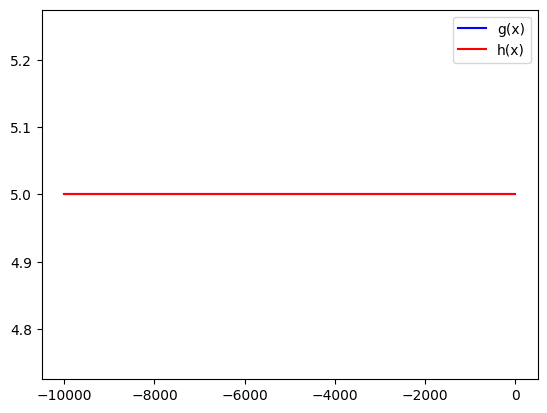

In [9]:
print("The two functions look identical near the origin")
# qx = np.linspace(100, 10000, 100)
qx = np.linspace(-5, 10, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(h)(qx)

plt.plot(qx, qyg, label="g(x)", color="blue")
plt.plot(qx, qym, label="h(x)", color="red")
plt.legend()
plt.show()

print("The two functions diverge further from the origin in the positive direction.")
qx = np.linspace(5, 100000, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(h)(qx)

plt.plot(qx, qyg, label="g(x)", color="blue")
plt.plot(qx, qym, label="h(x)", color="red")
plt.legend()
plt.show()

print("There is zero error to the left of the origin.")
qx = np.linspace(-10000, -5, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(h)(qx)

plt.plot(qx, qyg, label="g(x)", color="blue")
plt.plot(qx, qym, label="h(x)", color="red")
plt.legend()
plt.show()


## Training a model with the same architecture

First let's generate training, validation, and evaluation samples.

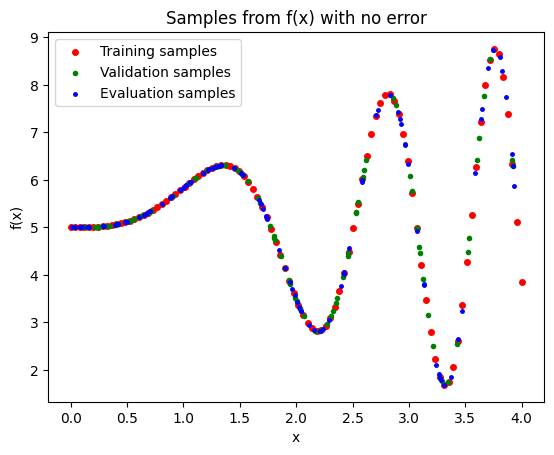

In [13]:
from helpers import sample, UniqueRandomFloatGenerator
generator = UniqueRandomFloatGenerator(x[0], x[-1])
training = (x, y)
validation = sample(f, generator.next(100))
evaluation = sample(f, generator.next(100))

plt.scatter(training[0], training[1], marker=".", s=64, color="red", label="Training samples")
plt.scatter(validation[0], validation[1], marker=".", s=36, color="green", label="Validation samples")
plt.scatter(evaluation[0], evaluation[1], marker=".", s=25, color="blue", label="Evaluation samples")

# Add title and labels
plt.title("Samples from f(x) with no error")
plt.xlabel("x")
plt.ylabel("f(x)")

plt.legend()

# Display the plot
plt.show()

Next let's train the model.

Epoch [10/1000], Loss: 4.7931
Epoch [20/1000], Loss: 3.4942
Epoch [30/1000], Loss: 2.8797
Epoch [40/1000], Loss: 2.6145
Epoch [50/1000], Loss: 2.5038
Epoch [60/1000], Loss: 2.4559
Epoch [70/1000], Loss: 2.4340
Epoch [80/1000], Loss: 2.4231
Epoch [90/1000], Loss: 2.4165
Epoch [100/1000], Loss: 2.4120
Epoch [110/1000], Loss: 2.4080
Epoch [120/1000], Loss: 2.4045
Epoch [130/1000], Loss: 2.4013
Epoch [140/1000], Loss: 2.3985
Epoch [150/1000], Loss: 2.3958
Epoch [160/1000], Loss: 2.3934
Epoch [170/1000], Loss: 2.3913
Epoch [180/1000], Loss: 2.3895
Epoch [190/1000], Loss: 2.3878
Epoch [200/1000], Loss: 2.3861
Epoch [210/1000], Loss: 2.3845
Epoch [220/1000], Loss: 2.3829
Epoch [230/1000], Loss: 2.3813
Epoch [240/1000], Loss: 2.3798
Epoch [250/1000], Loss: 2.3783
Epoch [260/1000], Loss: 2.3768
Epoch [270/1000], Loss: 2.3752
Epoch [280/1000], Loss: 2.3737
Epoch [290/1000], Loss: 2.3723
Epoch [300/1000], Loss: 2.3708
Epoch [310/1000], Loss: 2.3693
Epoch [320/1000], Loss: 2.3679
Epoch [330/1000],

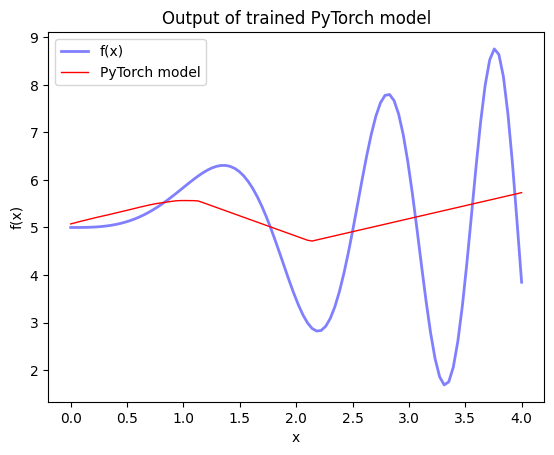

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim


# Hyperparameters
# input_size = 10
hidden_size = len(wb[1])
# output_size = 1
learning_rate = 0.01
num_epochs = 1000


# Generate some synthetic data for training
torch.manual_seed(0)  # For reproducibility
# X_train = torch.randn(100, input_size)  # 100 samples, input_size features
# y_train = torch.randn(100, output_size)  # 100 samples, output_size targets
X_train = torch.tensor([[w] for w in training[0]], dtype=torch.float32)
Y_train = torch.tensor([[w] for w in training[1]], dtype=torch.float32)

# Initialize model, loss function, and optimizer
model = PyTorchModel(len(wb[1]))
# model = SimpleModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Clear the gradients
    loss.backward()        # Backpropagate
    optimizer.step()       # Update parameters
    
    # Print progress every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed.")

h2 = model.single
results3 = Evaluate(x, f, h2)

print(f"mean error for model_fun(x): {results3.mean}")

plt.plot(x, results3.y1, label="f(x)", color="#8080ff", linewidth=2)
plt.plot(x, results3.y2, label="PyTorch model", color="red", linewidth=1)
plt.title("Output of trained PyTorch model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [ ]:
print(torch.get_default_device())

cpu


## TODO

* Hat function basis.
* Write introduction.
  * Goals.
  * Overview.
* Write prerequisites.
* Explain matrix math and impact of removing relu.
* Function to calculate error - used for evaluation.
* Display error for python model and pytorch model.
* Train pytorch model on f.
  * Show how model evolves over time.
* Train pytorch model on f with noise.
  * Show how model evolves over time.
  * Show overfitting.

$\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $

In [ ]:
# %matplotlib widget
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Generate some data for the height field
# x = np.linspace(-5, 5, 100)
# y = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(x, y)
# Z = np.sin(np.sqrt(X**2 + Y**2))

# # Create a figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the surface
# surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# # Add labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Height')
# plt.title('3D Height Field')

# # Show the plot
# plt.show()